# 3. Connecting the APIs together

So far, we've only looked at the `/works` API, but Wellcome Collection has a few more which we can make use of. As well as `/works`, we can also use `/images` and `/concepts`. 

In this notebook, we'll look at how we can use these APIs together to get more complete picture of the data in the catalogue.

In [2]:
base_url = "https://api.wellcomecollection.org/catalogue/v2/"

We've already seen what the works API can do - let's fetch a work and have a look at the images and concepts which are linked to it.

In [124]:
import requests

work = requests.get(
    base_url + "works/zfhdzwm2",
    params={"include": "subjects,images"},
).json()

list(work)

['physicalDescription',
 'subjects',
 'workType',
 'thumbnail',
 'alternativeTitles',
 'id',
 'title',
 'type',
 'images',
 'availabilities']

## 3.2 Concepts

We can scan through the list of subjects on the work and see which concepts they're composed of.

In [125]:
for subject in work["subjects"]:
    print("Subject:", subject["label"])
    print("Concepts:")
    for concept in subject['concepts']:
        print("-", concept['label'])
    print()

Subject: Materia medica
Concepts:
- Materia medica

Subject: Botany, Medical
Concepts:
- Botany, Medical

Subject: Materia Medica - history
Concepts:
- Materia Medica
- history

Subject: Plants, Medicinal - history
Concepts:
- Plants, Medicinal
- history



In [36]:
unique_concepts = set()
for subject in work["subjects"]:
    for concept in subject['concepts']:
        unique_concepts.add(concept['label'])

unique_concepts

{'Botany, Medical',
 'Materia Medica',
 'Materia medica',
 'Plants, Medicinal',
 'history'}

Each of these concepts has a unique identifier, which we can use to look up the concept in the `/concepts` API.

In [38]:
concept_ids = [
    concept['id']
    for subject in work["subjects"]
    for concept in subject['concepts']
]

first_concept_id = concept_ids[0]

response = requests.get(
    base_url + "concepts/" + first_concept_id
).json()

response

{'id': 'k6zqasmn',
 'identifiers': [{'identifierType': {'id': 'lc-subjects',
    'label': 'Library of Congress Subject Headings (LCSH)',
    'type': 'IdentifierType'},
   'type': 'Identifier',
   'value': 'sh85082055'}],
 'label': 'Materia medica',
 'alternativeLabels': [],
 'type': 'Concept',
 'sameAs': []}

This tells us what Wellcome Collection knows about that concept, and where it appears in other controlled vocabularies. We now know that `Materia medica` has the ID `k6zqasmn` in Wellcome Collection's APIs, and is known by `sh85082055` in the Library of Congress Subject Headings (LCSH) scheme. Some concepts will also include alternative names (`alternativeLabels`) and equivalent concepts (`sameAs`), which can be useful for searching.

## 3.3 Images

Now, let's have a look at the images on the work.

In [39]:
work['images']

[{'id': 'z5hm94pv', 'type': 'Image'},
 {'id': 'wp5jqhsf', 'type': 'Image'},
 {'id': 'c8sut4vz', 'type': 'Image'},
 {'id': 'h23m64tf', 'type': 'Image'},
 {'id': 'y9amq6mu', 'type': 'Image'},
 {'id': 'ezusa2gn', 'type': 'Image'},
 {'id': 'tgw7w7tf', 'type': 'Image'},
 {'id': 'vn6z5hvc', 'type': 'Image'},
 {'id': 'bvynt4ws', 'type': 'Image'},
 {'id': 'yryezh6h', 'type': 'Image'},
 {'id': 'h4cgtthv', 'type': 'Image'},
 {'id': 'czetxzrc', 'type': 'Image'},
 {'id': 'u3nxp7t5', 'type': 'Image'}]

Again, each one has an ID which corresponds to a document in the `/images` API. Let's fetch one of these images and see what we can find out about it.

In [41]:
response = requests.get(
    base_url + "images/" + work['images'][0]['id']
).json()

response

{'locations': [{'url': 'https://iiif.wellcomecollection.org/image/L0063644/info.json',
   'credit': 'Wellcome Collection',
   'license': {'id': 'pdm',
    'label': 'Public Domain Mark',
    'url': 'https://creativecommons.org/share-your-work/public-domain/pdm/',
    'type': 'License'},
   'accessConditions': [{'method': {'id': 'view-online',
      'label': 'View online',
      'type': 'AccessMethod'},
     'status': {'id': 'open', 'label': 'Open', 'type': 'AccessStatus'},
     'type': 'AccessCondition'}],
   'locationType': {'id': 'iiif-image',
    'label': 'IIIF Image API',
    'type': 'LocationType'},
   'type': 'DigitalLocation'}],
 'source': {'id': 'zfhdzwm2', 'title': 'Ambrosia altera.', 'type': 'Work'},
 'aspectRatio': 1.3333334,
 'thumbnail': {'url': 'https://iiif.wellcomecollection.org/image/L0063644/info.json',
  'credit': 'Wellcome Collection',
  'license': {'id': 'pdm',
   'label': 'Public Domain Mark',
   'url': 'https://creativecommons.org/share-your-work/public-domain/pdm

We're looking at data about the image in the context of Wellcome Collection here - the title of the work it's from (`source.title`), the rights statements associated with it (`locations[0].license.label`), its average colour (`averageColor`) and aspect ratio (`aspectRatio`). 

Let's look at the average colour of the images which are associated with this work.

In [42]:
for image in work['images']:
    response = requests.get(
        base_url + "images/" + image['id']
    ).json()
    print(image['id'], response['averageColor'])

z5hm94pv #1c1c1b
wp5jqhsf #403d3b
c8sut4vz #222120
h23m64tf #5e5546
y9amq6mu #383736
ezusa2gn #383532
tgw7w7tf #594735
vn6z5hvc #3a3733
bvynt4ws #5a5a5d
yryezh6h #5f574a
h4cgtthv #8e827f
czetxzrc #332f2a
u3nxp7t5 #3e3d38


## 3.4 Fetching actual images

In addition to the first-class APIs for `/works`, `/images` and `/concepts`, the Wellcome Collection site use a few auxiliary APIs for different purposes. 

For example, the `/images` API returns a list of image metadata, but not the actual images themselves. To get the images, we need to use the [IIIF](https://iiif.io/) (that's International Image Interoperability Framework) API. The IIIF specification is a standardised way of fetching images from a server, which is used by many cultural institutions.

Let's use one of our images from the last section to see how this works.

In [45]:
image_id = work['images'][0]['id']
response = requests.get(base_url + "images/" + image_id).json()
response

{'locations': [{'url': 'https://iiif.wellcomecollection.org/image/L0063644/info.json',
   'credit': 'Wellcome Collection',
   'license': {'id': 'pdm',
    'label': 'Public Domain Mark',
    'url': 'https://creativecommons.org/share-your-work/public-domain/pdm/',
    'type': 'License'},
   'accessConditions': [{'method': {'id': 'view-online',
      'label': 'View online',
      'type': 'AccessMethod'},
     'status': {'id': 'open', 'label': 'Open', 'type': 'AccessStatus'},
     'type': 'AccessCondition'}],
   'locationType': {'id': 'iiif-image',
    'label': 'IIIF Image API',
    'type': 'LocationType'},
   'type': 'DigitalLocation'}],
 'source': {'id': 'zfhdzwm2', 'title': 'Ambrosia altera.', 'type': 'Work'},
 'aspectRatio': 1.3333334,
 'thumbnail': {'url': 'https://iiif.wellcomecollection.org/image/L0063644/info.json',
  'credit': 'Wellcome Collection',
  'license': {'id': 'pdm',
   'label': 'Public Domain Mark',
   'url': 'https://creativecommons.org/share-your-work/public-domain/pdm

As well as the metadata we saw in the last section, we can also see a URL which will lead us to the image itself (`thumbnail.url`).

In [46]:
iiif_url = response["thumbnail"]["url"]
iiif_url

'https://iiif.wellcomecollection.org/image/L0063644/info.json'

In [47]:
response = requests.get(iiif_url).json()
response

{'@context': 'http://iiif.io/api/image/2/context.json',
 '@id': 'https://iiif.wellcomecollection.org/image/L0063644',
 '@type': 'ImageService2',
 'profile': ['http://iiif.io/api/image/2/level2.json',
  {'formats': ['jpg', 'tif', 'gif', 'png'],
   'qualities': ['bitonal', 'default', 'gray', 'color'],
   'supports': ['regionByPx',
    'sizeByW',
    'sizeByWhListed',
    'cors',
    'regionSquare',
    'sizeByDistortedWh',
    'canonicalLinkHeader',
    'sizeByConfinedWh',
    'sizeByPct',
    'jsonldMediaType',
    'regionByPct',
    'rotationArbitrary',
    'sizeByH',
    'baseUriRedirect',
    'rotationBy90s',
    'profileLinkHeader',
    'sizeByForcedWh',
    'sizeByWh',
    'mirroring']}],
 'protocol': 'http://iiif.io/api/image',
 'width': 6666,
 'height': 4992,
 'sizes': [{'width': 1024, 'height': 767},
  {'width': 400, 'height': 300},
  {'width': 200, 'height': 150},
  {'width': 100, 'height': 75}],
 'tiles': [{'width': 512,
   'height': 512,
   'scaleFactors': [1, 2, 4, 8, 16, 32

Again, this gives us some more metadata about the image, but not the image itself! This time, the metadata is about the specific digital image (eg. the size of the image, the format, etc.) rather than the work that the image is from.

We can augment our IIIF URL using a structured set of parameters ([documented here](https://developers.wellcomecollection.org/api/iiif#tag/IIIF-Image-API/operation/get-image)) to get the image in the format we want.

The following line assembles a URL which requests:
- the full image (`full`), rather than a specific region
- 640 pixels wide, and at the corresponding height which preserves its aspect ratio (`640,`)
- without rotation (`0`)
- in colour (`default`), rather than greyscale, bitonal, etc.
- in `.jpg` format (`jpg`)

In [48]:
thumbnail_url = iiif_url.replace("info.json", "full/640,/0/default.jpg")

In [49]:
response = requests.get(thumbnail_url)

We can use a couple of Python libraries to display the image in our notebook.

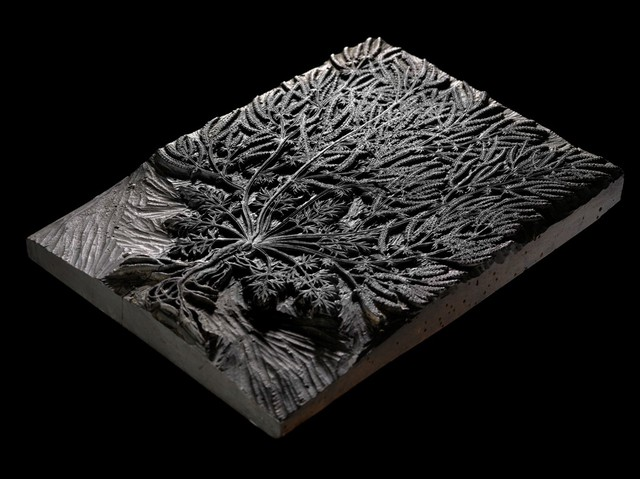

In [50]:
from PIL import Image
from io import BytesIO

image = Image.open(BytesIO(response.content))
image

In [51]:
image.size

(640, 479)

## 3.5 Visually similar images

The images API also allows us to specify some extra parameters. One of them return images which are visually similar to the one we've just fetched.

Let's use our image from the last section as an example.

In [118]:
image_id = work['images'][0]['id']

response = requests.get(
    base_url + "images/" + image_id,
    params={"include": "visuallySimilar"},
).json()

Each of the results in the response's `visuallySimilar` field is another image, with the same structure as our source image. We can use the same IIIF API to fetch the images themselves.

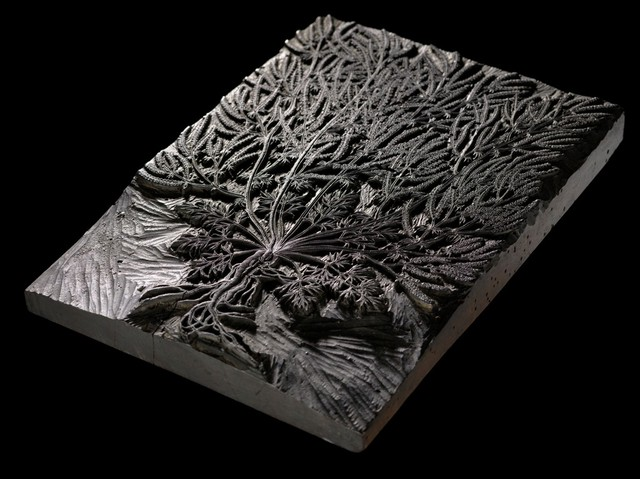

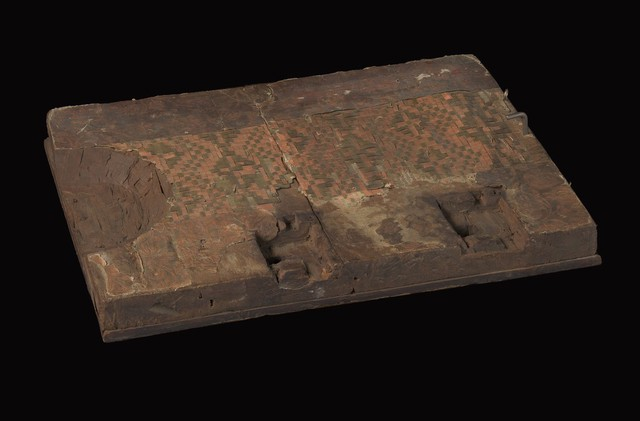

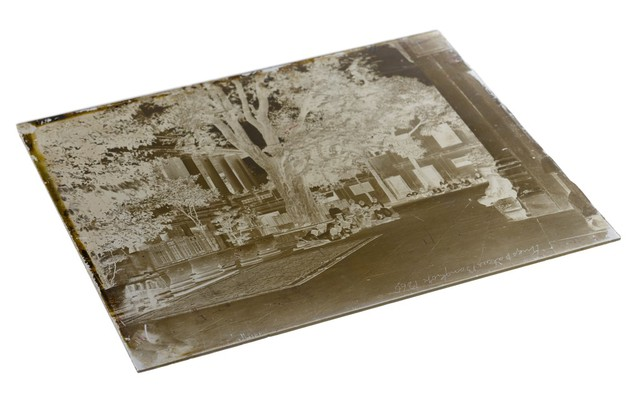

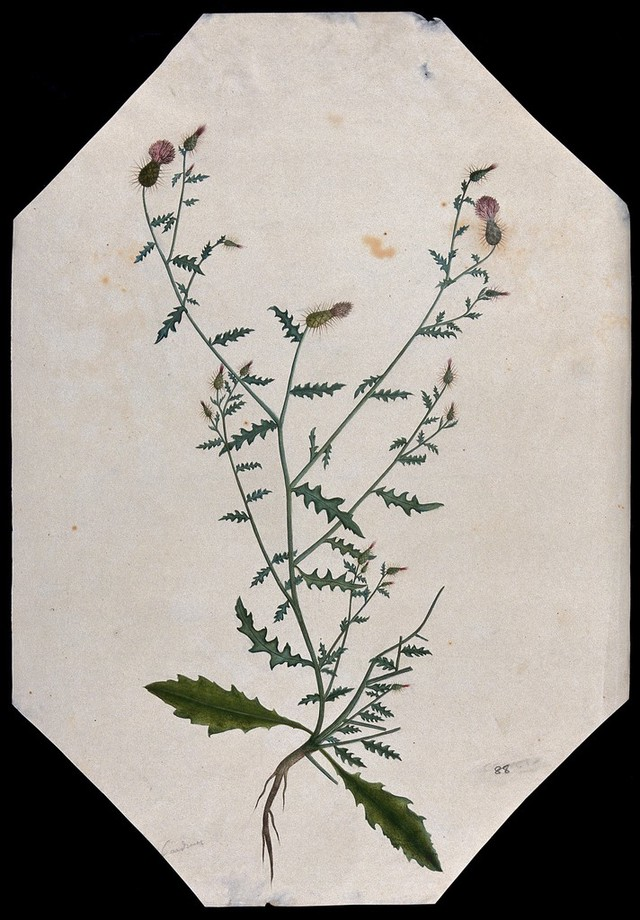

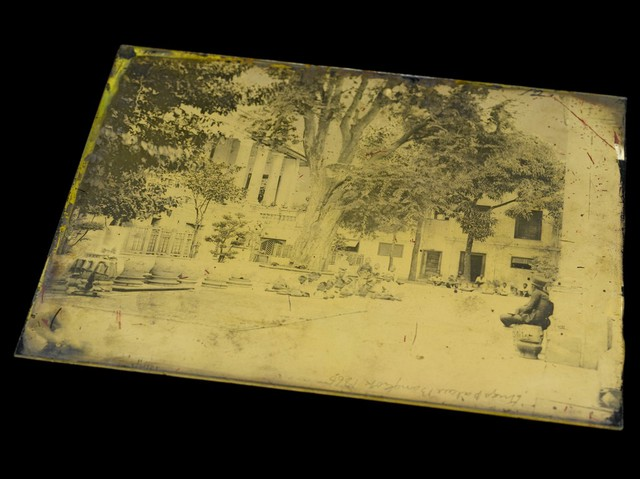

In [121]:
for image in response['visuallySimilar']:
    thumbnail_url = image['thumbnail']['url'].replace(
        "info.json", "full/640,/0/default.jpg"
    )

    thumbnail_response = requests.get(thumbnail_url).content
    image = Image.open(BytesIO(thumbnail_response))
    display(image)


## 3.6 Getting IIIF images for digitised works

We can use a similar approach to fetch images for digitised works (eg individual pages of a fully digitised book). Works which have been digitised will all have an `items` field, which contains a URL for a IIIF presentation of the work.

We can filter the works API for works which have a `workType` of `a` (aka "Books") and `items.locations.locationType` of `iiif-presentation`.

In [68]:
response = requests.get(
    base_url + "works",
    params={
        "query": "woodblock",
        "workType": "a",
        "items.locations.locationType": "iiif-presentation",
        "include": "items",
    },
).json()

In [69]:
response['totalResults']

2

In [113]:
digitised_work = response['results'][0]
digitised_work['id']

'znegz554'

In [126]:
list(digitised_work)

['physicalDescription',
 'items',
 'workType',
 'alternativeTitles',
 'id',
 'title',
 'type',
 'availabilities']

Let's get the IIIF presentation for the digitised work, and have a look at the IIIF response.

In [84]:
for item in digitised_work["items"]:
    for location in item["locations"]:
        if location["locationType"]["id"] == "iiif-presentation":
            presentation_url = location["url"]
            break

presentation_url

'https://iiif.wellcomecollection.org/presentation/v2/b32988783'

In [87]:
presentation_response = requests.get(presentation_url).json()

We want the `canvases` from this response, which contain the images for each page.

In [96]:
canvases = presentation_response["sequences"][0]["canvases"]
len(canvases)

68

Each canvas contains an image resource, which we can use to get the IIIF image for that page, as we did in the last section.

In [114]:
iiif_image_urls = [
    canvas['images'][0]['resource']['@id']
    for canvas in canvases
]
iiif_image_urls[:5]

['https://iiif.wellcomecollection.org/image/b32988783_0001.jp2/full/660,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b32988783_0002.jp2/full/484,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b32988783_0003.jp2/full/484,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b32988783_0004.jp2/full/672,1024/0/default.jpg',
 'https://iiif.wellcomecollection.org/image/b32988783_0005.jp2/full/672,1024/0/default.jpg']

Let's display the first few images

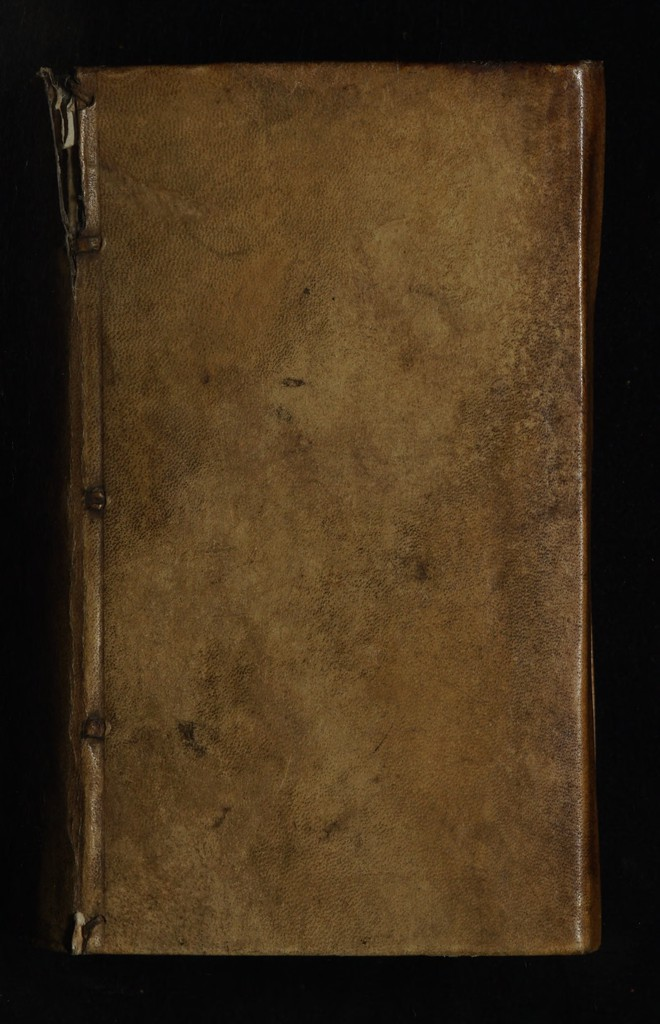

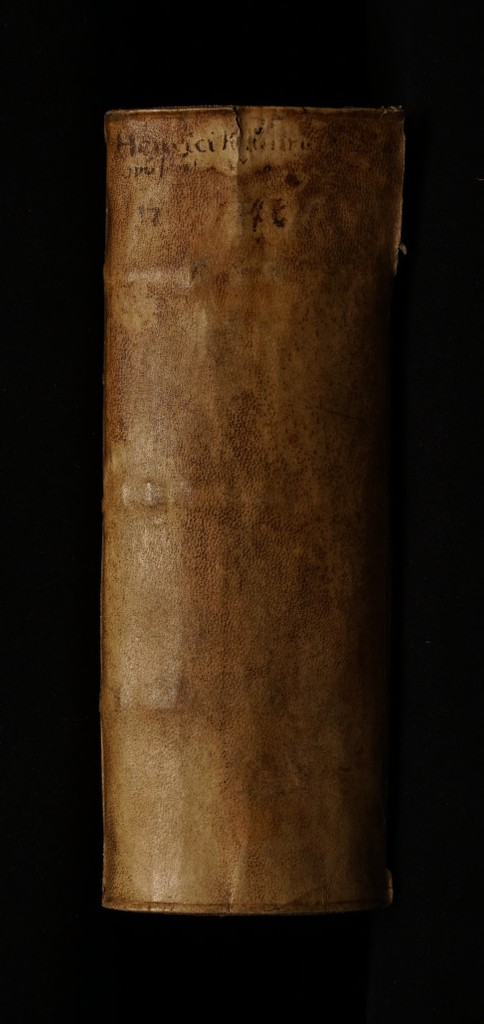

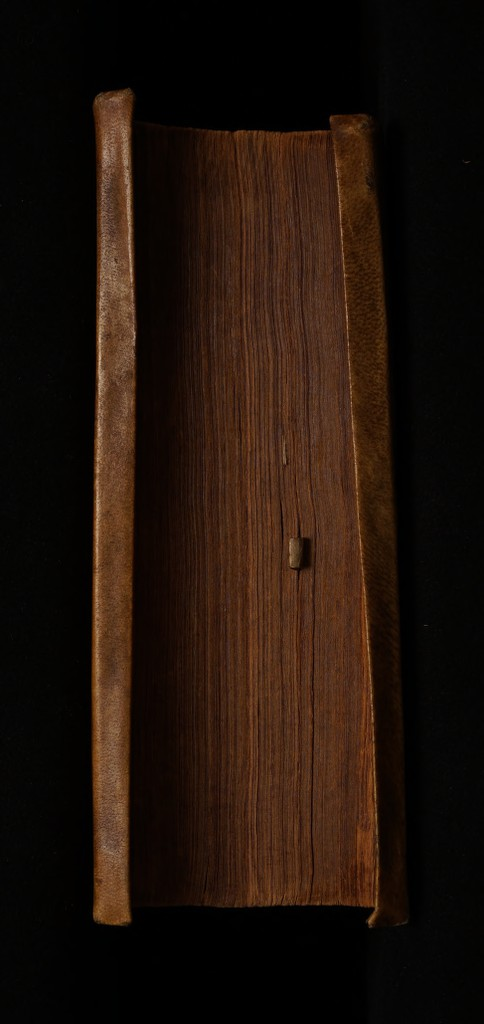

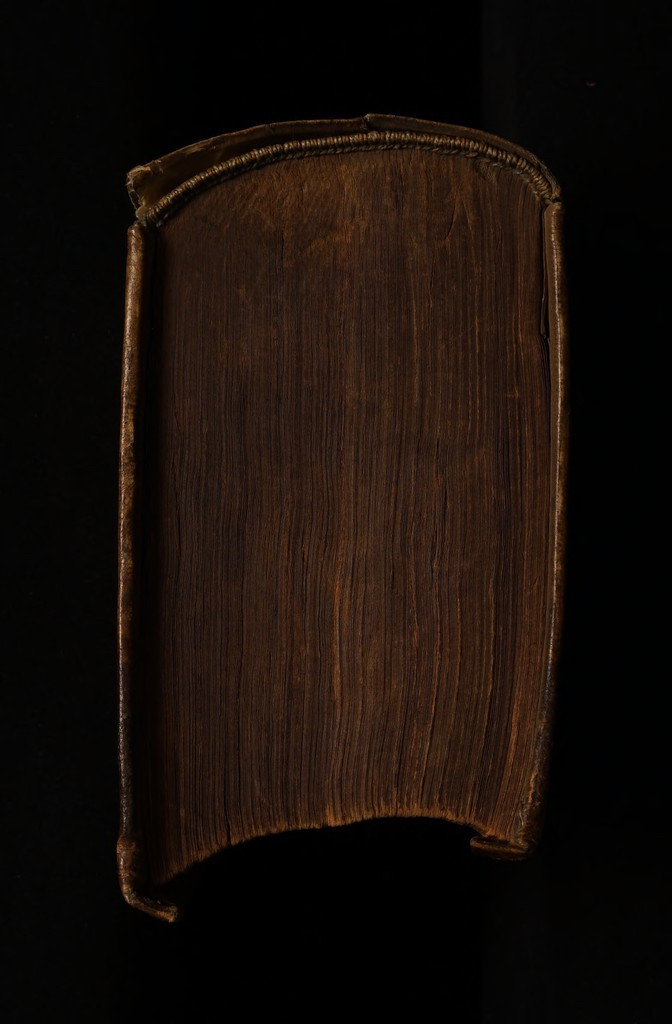

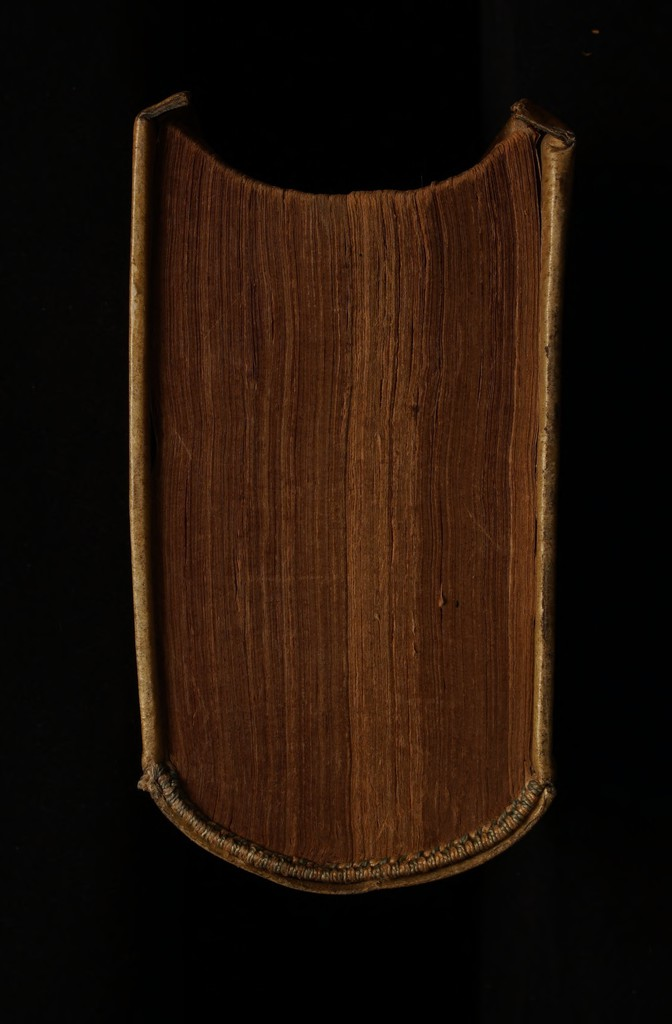

In [115]:
for iiif_image_url in iiif_image_urls[:5]:
    image_bytes = requests.get(iiif_image_url).content
    image = Image.open(BytesIO(image_bytes))    
    display(image)

## Exercises

1. Display the next 5 pages of our digitised work.
2. Have a look at the [developers documentation](https://developers.wellcomecollection.org/api/catalogue#tag/Images/operation/getImages) and figure out how to filter an image search by colour. See if you can find some pink elephants (hint: `#b23f72` is the hex code for a nice bright pink).
3. Find an image's visually similar images, and then find the visually similar images for all of those images.
4. Find a concept which includes some `alternativeLabels`. See whether you can find any works which have been tagged with those alternative labels.
5. Find another work which has a `workType` of `a` (aka "Books") and `items.locations.locationType` of `iiif-presentation`. Fetch the IIIF presentation for the digitised work, and explore its images.